In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
date = pd.date_range("2023-05-01", "2023-07-31", freq="D")
cohorts = pd.to_datetime(["2023-06-01", "2023-07-15", "2024-01-01"]).date
units = range(1, 100+1)

np.random.seed(1996)

df_heter = pd.DataFrame(dict(
    date = np.tile(date.date, len(units)),  # T*n many
    unit = np.repeat(units, len(date)),  # n*T many
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    # sequence of numbers from 0 to 6 that represents the weekly seasonality
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    y = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

In [4]:
df_heter

,date,unit,cohort,unit_fe,time_fe,week_day,w_seas,trend,day,treat,y0,y1,tau,y
0,2023-05-01,1,2024-01-01,-2.856116,-1.126136,0,5,0.000000,0,0,9.472470,9.472470,0.0,9.472470
1,2023-05-02,1,2024-01-01,-2.856116,-1.424040,1,4,0.014286,1,0,9.451860,9.451860,0.0,9.451860
2,2023-05-03,1,2024-01-01,-2.856116,0.973008,2,3,0.028571,2,0,9.565999,9.565999,0.0,9.565999
3,2023-05-04,1,2024-01-01,-2.856116,1.507362,3,2,0.042857,3,0,9.587002,9.587002,0.0,9.587002
4,2023-05-05,1,2024-01-01,-2.856116,-0.140686,4,1,0.057143,4,0,9.498885,9.498885,0.0,9.498885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,2023-07-27,100,2023-07-15,6.440784,0.280488,3,2,1.242857,87,1,12.585038,13.585038,1.0,13.585038
9196,2023-07-28,100,2023-07-15,6.440784,-1.044357,4,1,1.257143,88,1,12.513082,13.513082,1.0,13.513082
9197,2023-07-29,100,2023-07-15,6.440784,-0.987179,5,0,1.271429,89,1,12.510226,13.510226,1.0,13.510226
9198,2023-07-30,100,2023-07-15,6.440784,0.836278,6,1,1.285714,90,1,12.635685,13.635685,1.0,13.635685


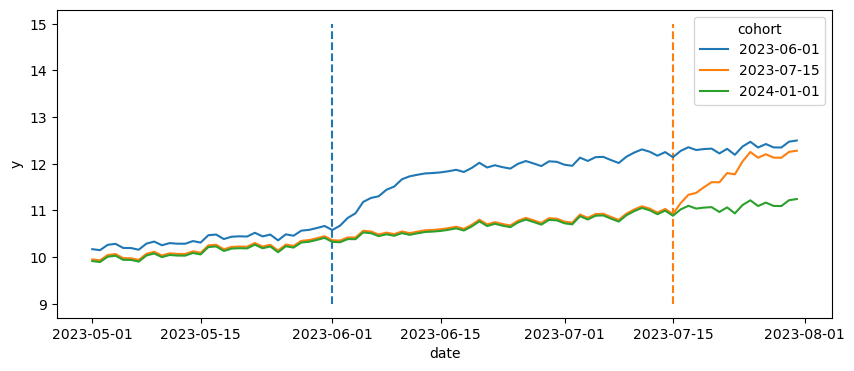

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["y"]
          .mean()
          .reset_index()),
    x="date",
    y = "y",
    hue="cohort",
);

In [5]:
# TWFE model
formula = f"""y ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.7928604436229151
True Effect:  0.8589743589743589


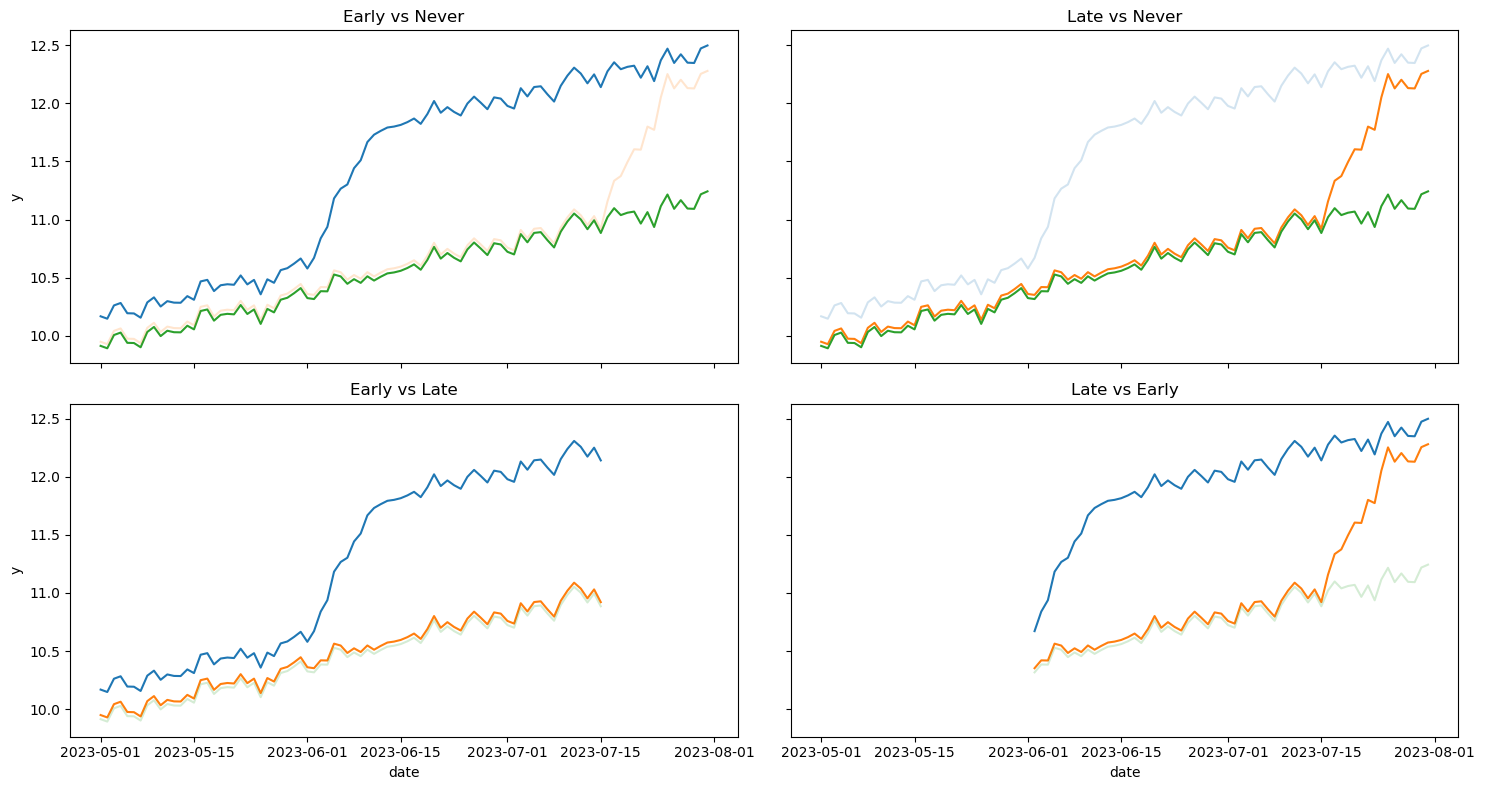

In [6]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["y"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):
    
    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))
    
    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="y",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "y",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )
    
    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();